In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [8]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [72]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

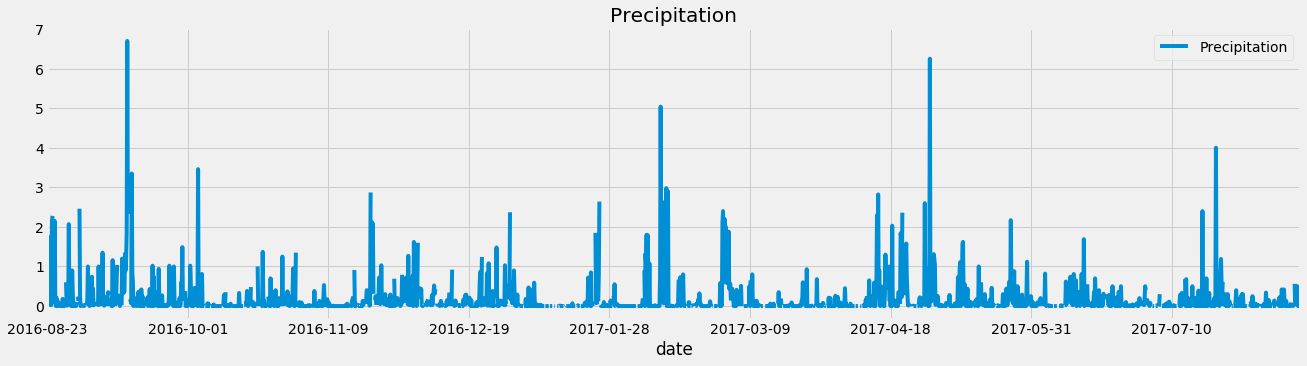

In [139]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

last_date= session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point in the database

year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >="2016-08-23").all() 

# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df = pd.DataFrame(precip)
precip_df = precip_df.set_index('date')
precip_df = precip_df.rename(columns = {'prcp' : 'Precipitation'})

# Sort the dataframe by date

date_order = precip_df.sort_values('date')
# Use Pandas Plotting with Matplotlib to plot the data
precip_data = date_order.plot(kind='line', figsize=(20,5))
plt.title("Precipitation")
plt.savefig('images/Precipitation_graph')

![precipitation](Images/precipitation.png)

In [67]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = precip_df.describe()
summary_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [70]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).count() 
print(stations)

9


In [94]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = (session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all())
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [128]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
summary_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station =="USC00519281")
print(f"Min Temp:{summary_temps[0][0]} Fahrenheit, Max Temp: {summary_temps[0][1]} Fahrenheit, Average Temp: {round(summary_temps[0][2], 2)} Fahrenheit.")




Min Temp:54.0 Fahrenheit, Max Temp: 85.0 Fahrenheit, Average Temp: 71.66 Fahrenheit.


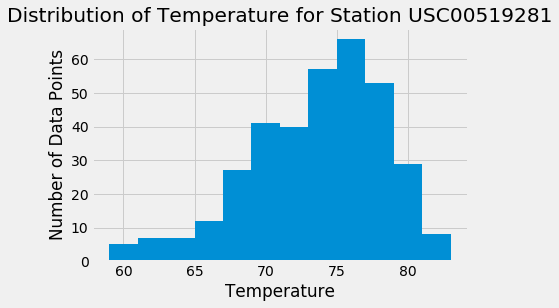

In [141]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year = session.query(Measurement.date, Measurement.tobs, Measurement.station).\
    filter(Measurement.date >="2016-08-23").\
    filter(Measurement.station =="USC00519281")
last_year_df = pd.DataFrame(last_year)
plt.hist(last_year_df.tobs, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Number of Data Points")
plt.title("Distribution of Temperature for Station USC00519281")
plt.savefig("images/Temp_hist")

In [140]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [194]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start = '2017-03-01'
end = '2017-03-09'
def calc_temps(start, end):
     return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start).filter(Measurement.date <= end).all()
temps = (calc_temps(start, end)) 
print(temps)

[(62.0, 70.58181818181818, 78.0)]


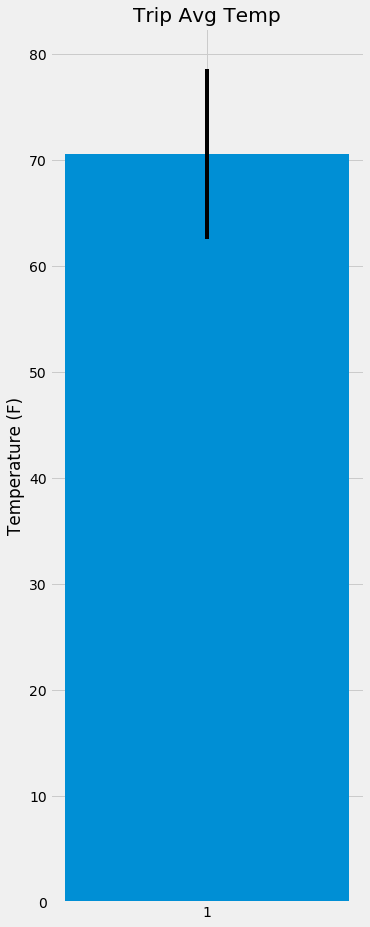

In [196]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak = temps[0][2] - temps[0][0]
avg_temp = temps[0][1]


fig, ax = plt.subplots(figsize = (5, 15))

ax.bar(1, avg_temp, yerr = peak/2, width = 0.5)

ax.set_xticks([1])
plt.title('Trip Avg Temp')
plt.ylabel('Temperature (F)')

plt.savefig("Images/avg_temp")

plt.show()



In [193]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = ([Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation])

rainfall = session.query(*sel).filter(Station.station == Measurement.station).\
                   filter(Measurement.date >= start).\
                   filter(Measurement.date <= end).\
                   group_by(Station.station).\
                   order_by(func.sum(Measurement.prcp).desc()).all()
print(rainfall)


[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


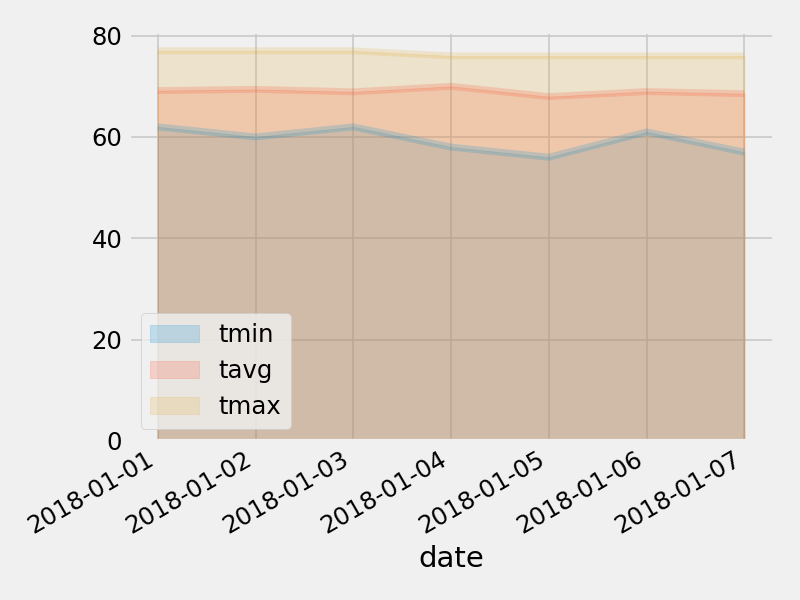

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
